# Basic ML Models

## Load Dataset

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/df.csv')

info_df = pd.read_csv('data/info_df.csv')
smile_features = pd.read_csv("data/smile_features.csv")
utterance_features = pd.read_csv("data/utterance_features.csv")

smile_columns = smile_features.columns[1:].tolist()
utterance_columns = utterance_features.columns[1:].tolist()

### Check missing data and remove the missing columns

In [2]:
missing_columns = df.columns[df.isnull().any()]
print("Columns with missing values:", missing_columns.tolist())
for col in missing_columns:
    missing_count = df[col].isnull().sum()
    print(f"Column '{col}' has {missing_count} missing values.")

missing_split_values = df[df[missing_columns].isnull().any(axis=1)]['Split']
print("Split values for rows with missing values:", missing_split_values.tolist())

# drop columns with missing values
df = df.drop(columns=missing_columns)
utterance_columns = [col for col in utterance_columns if col not in missing_columns]

all_columns = smile_columns + utterance_columns

Columns with missing values: ['Avg_Utterance_Duration_Ellie', 'Avg_Word_Count_Ellie']
Column 'Avg_Utterance_Duration_Ellie' has 3 missing values.
Column 'Avg_Word_Count_Ellie' has 3 missing values.
Split values for rows with missing values: ['dev', 'dev', 'test']


## Run ML models

In [3]:
from src.evaluate_ml_models import MLPipeline
from src.evaluate_ml_models import set_seed_everything
set_seed_everything(42)

pipeline = MLPipeline(df, feature_cols=all_columns)
result, report = pipeline.evaluate_models(baseline=True, report=True)
display(result)

,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,Baseline (Majority Voting),0.702128,0.412500,0.500000,0.351064,0.500000
1,SVM,0.659574,0.620968,0.590909,0.618774,0.634199
2,KNN,0.744681,0.587719,0.559524,0.747093,0.591991
3,RandomForest,0.702128,0.472756,0.596320,0.605556,0.520563
4,LogisticRegression,0.638298,0.576127,0.588745,0.575000,0.577922
5,GradientBoosting,0.659574,0.450292,0.640693,0.473837,0.490260
6,XGBoost,0.765957,0.662753,0.744589,0.744643,0.648268


### Result Visualization

Baseline found...


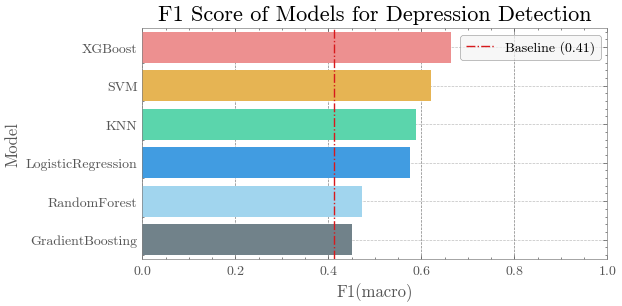

Baseline found...


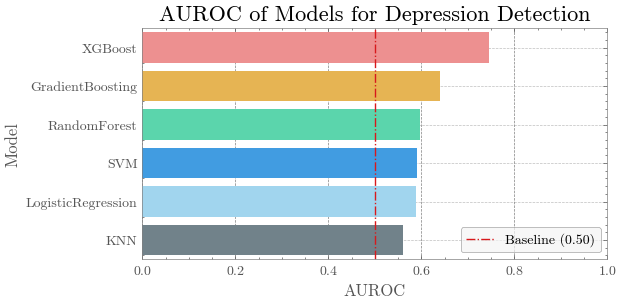

In [4]:
from src import plot_result, plot_cm
import os
os.makedirs("results/ml_result", exist_ok=True)

plot_result(result, metric='F1(macro)', sort=True, title="F1 Score of Models for Depression Detection", save_path="results/ml_result/feature_all_model_ml_metric_f1.png")
plot_result(result, metric='AUROC', sort=True, title="AUROC of Models for Depression Detection", save_path="results/ml_result/feature_all_model_ml_metric_auroc.png")

In [5]:
from sklearn.metrics import confusion_matrix

classified_result = report['XGBoost']['per_sample']
classified_result = classified_result.merge(
    df[['Participant_ID', 'Gender']],
    on='Participant_ID',
    how='left'
)
classified_result['GENDER'] = classified_result['Gender'].apply(lambda x: 'F' if x == 0 else 'M')

conf_matrices_by_gender = {}
for gender in ['F', 'M']:
    subset = classified_result[classified_result['GENDER'] == gender]
    cm = confusion_matrix(subset['True Label'], subset['Predicted Label'], labels=[0, 1])
    conf_matrices_by_gender[gender] = cm
conf_matrices_by_gender

{'F': array([[16,  1],
        [ 4,  3]], dtype=int64),
 'M': array([[15,  1],
        [ 5,  2]], dtype=int64)}

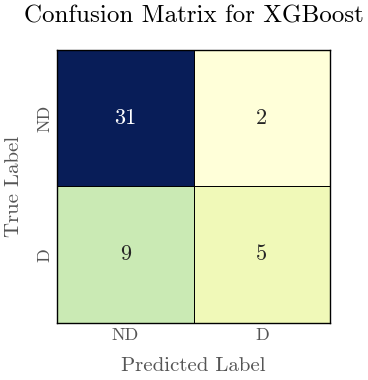

In [7]:
plot_cm(report['XGBoost']['confusion_matrix'], title="Confusion Matrix for XGBoost", save_path="results/ml_result/cm_feature_all_xgb.png")

## Ablation Study
- Features: All, openSMILE, utterance
- feature selection: None, kbest, model

In [8]:
# All features

# k-best top 50
display(pipeline.evaluate_models(
    use_feature_selection=True,
    selection_method='kbest',
    k_features=50,
    show_selected_features=True
))

# model-based with random forest
display(pipeline.evaluate_models(
    use_feature_selection=True,
    selection_method='model',
    show_selected_features=True
))

[Feature Selection: kbest] Selected 49 features:
['F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'mfcc4_sma3_amean', 'mf

,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,SVM,0.617021,0.559375,0.547619,0.558468,0.562771
1,KNN,0.680851,0.461421,0.531385,0.518939,0.505411
2,RandomForest,0.702128,0.472756,0.601732,0.605556,0.520563
3,LogisticRegression,0.680851,0.591304,0.586580,0.602273,0.587662
4,GradientBoosting,0.680851,0.540117,0.653680,0.576786,0.546537
5,XGBoost,0.744681,0.618919,0.673160,0.711382,0.612554


[Feature Selection: model] Selected 46 features:
['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3

,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,SVM,0.638298,0.576127,0.521645,0.575000,0.577922
1,KNN,0.702128,0.472756,0.701299,0.605556,0.520563
2,RandomForest,0.702128,0.472756,0.574675,0.605556,0.520563
3,LogisticRegression,0.680851,0.610282,0.567100,0.613122,0.608225
4,GradientBoosting,0.680851,0.505263,0.610390,0.557143,0.525974
5,XGBoost,0.765957,0.662753,0.688312,0.744643,0.648268


In [9]:
smile_pipeline = MLPipeline(df, feature_cols=smile_columns)

smile_result = smile_pipeline.evaluate_models()
display(smile_result)

# k-best top 50
display(smile_pipeline.evaluate_models(
    use_feature_selection=True,
    selection_method='kbest',
    k_features=50,
    show_selected_features=True
))

# model-based with random forest
display(smile_pipeline.evaluate_models(
    use_feature_selection=True,
    selection_method='model',
    show_selected_features=True
))

,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,SVM,0.659574,0.631373,0.651515,0.632407,0.654762
1,KNN,0.680851,0.505263,0.489177,0.557143,0.525974
2,RandomForest,0.702128,0.472756,0.577922,0.605556,0.520563
3,LogisticRegression,0.702128,0.657292,0.608225,0.653226,0.664502
4,GradientBoosting,0.680851,0.540117,0.666667,0.576786,0.546537
5,XGBoost,0.723404,0.533231,0.610390,0.696970,0.556277


[Feature Selection: kbest] Selected 49 features:
['F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'mfcc4_sma3_amean', 'mf

,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,SVM,0.574468,0.491342,0.443723,0.491342,0.491342
1,KNN,0.595745,0.373333,0.468615,0.333333,0.424242
2,RandomForest,0.702128,0.412500,0.606061,0.351064,0.500000
3,LogisticRegression,0.638298,0.536812,0.495671,0.542929,0.536797
4,GradientBoosting,0.744681,0.664286,0.582251,0.691892,0.653680
5,XGBoost,0.638298,0.536812,0.616883,0.542929,0.536797


[Feature Selection: model] Selected 35 features:
['F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'mfcc4_sma3_amean', 'mf

,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,SVM,0.638298,0.478800,0.445887,0.492857,0.495671
1,KNN,0.659574,0.450292,0.480519,0.473837,0.490260
2,RandomForest,0.659574,0.397436,0.585498,0.344444,0.469697
3,LogisticRegression,0.617021,0.465909,0.428571,0.471154,0.480519
4,GradientBoosting,0.702128,0.555405,0.627706,0.615854,0.561688
5,XGBoost,0.680851,0.461421,0.601732,0.518939,0.505411


In [10]:
utt_pipeline = MLPipeline(df, feature_cols=utterance_columns)

utt_result = utt_pipeline.evaluate_models()
display(utt_result)

# model-based with random forest
display(utt_pipeline.evaluate_models(
    use_feature_selection=True,
    selection_method='model',
    show_selected_features=True
))

,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,SVM,0.638298,0.510716,0.415584,0.521930,0.516234
1,KNN,0.595745,0.373333,0.456710,0.333333,0.424242
2,RandomForest,0.638298,0.439298,0.561688,0.445238,0.475108
3,LogisticRegression,0.617021,0.496429,0.647186,0.501351,0.501082
4,GradientBoosting,0.638298,0.510716,0.571429,0.521930,0.516234
5,XGBoost,0.680851,0.568279,0.614719,0.590643,0.567100


[Feature Selection: model] Selected 18 features:
['Num_Utterances_Ellie', 'Num_Utterances_Participant', 'Total_Duration_Ellie', 'Total_Duration_Participant', 'Avg_Utterance_Duration_Participant', 'Total_Interview_Duration', 'Total_Word_Count_Ellie', 'Total_Word_Count_Participant', 'Avg_Word_Count_Participant', 'Num_Turns', 'Total_Turns', 'Total_Silence_Duration', 'Avg_Silence_Duration', 'Max_Silence_Duration', 'Std_Silence_Duration', 'Silence_Duration_Ratio', 'Avg_Reaction_Time', 'Max_Reaction_Time']


,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,SVM,0.702128,0.412500,0.547619,0.351064,0.500000
1,KNN,0.574468,0.364865,0.387446,0.329268,0.409091
2,RandomForest,0.659574,0.450292,0.560606,0.473837,0.490260
3,LogisticRegression,0.617021,0.465909,0.545455,0.471154,0.480519
4,GradientBoosting,0.702128,0.555405,0.543290,0.615854,0.561688
5,XGBoost,0.659574,0.574661,0.504329,0.579762,0.572511


In [11]:
result.insert(0, 'Feature', 'All')
smile_result.insert(0, 'Feature', 'Audio')
utt_result.insert(0, 'Feature', 'Utterance')

In [12]:
def calculate_best_and_second_best(df, metric='F1(macro)'):
    high_perform_df = df.copy()
    
    high_perform_df['Model'] = high_perform_df['Model'].replace({
        'LogisticRegression': 'LR',
        'RandomForest': 'RF',
        'GradientBoosting': 'GB',
        'XGBoost': 'XGB',
    })

    best_idx = high_perform_df[metric].idxmax()
    second_best_idx = high_perform_df[metric].nlargest(2).idxmin()
    
    high_perform_df.loc[best_idx, 'Model'] += ' *'
    high_perform_df.loc[second_best_idx, 'Model'] += ' **'
    
    return high_perform_df.loc[[best_idx, second_best_idx]]

In [13]:
smile_result

,Feature,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,Audio,SVM,0.659574,0.631373,0.651515,0.632407,0.654762
1,Audio,KNN,0.680851,0.505263,0.489177,0.557143,0.525974
2,Audio,RandomForest,0.702128,0.472756,0.577922,0.605556,0.520563
3,Audio,LogisticRegression,0.702128,0.657292,0.608225,0.653226,0.664502
4,Audio,GradientBoosting,0.680851,0.540117,0.666667,0.576786,0.546537
5,Audio,XGBoost,0.723404,0.533231,0.610390,0.696970,0.556277


In [14]:
best_smile_result = calculate_best_and_second_best(smile_result)
best_utt_result = calculate_best_and_second_best(utt_result)
best_all_result = calculate_best_and_second_best(result)

selected_results = pd.concat(
    [best_all_result, best_smile_result, best_utt_result],
    axis=0,
    ignore_index=True
)
display(selected_results)

,Feature,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,All,XGB *,0.765957,0.662753,0.744589,0.744643,0.648268
1,All,SVM **,0.659574,0.620968,0.590909,0.618774,0.634199
2,Audio,LR *,0.702128,0.657292,0.608225,0.653226,0.664502
3,Audio,SVM **,0.659574,0.631373,0.651515,0.632407,0.654762
4,Utterance,XGB *,0.680851,0.568279,0.614719,0.590643,0.567100
5,Utterance,SVM **,0.638298,0.510716,0.415584,0.521930,0.516234


In [15]:
selected_results['Model'] = selected_results['Model'].replace('LogisticRegression', 'LR')
selected_results['Method'] = selected_results['Feature'] + ' - ' + selected_results['Model']

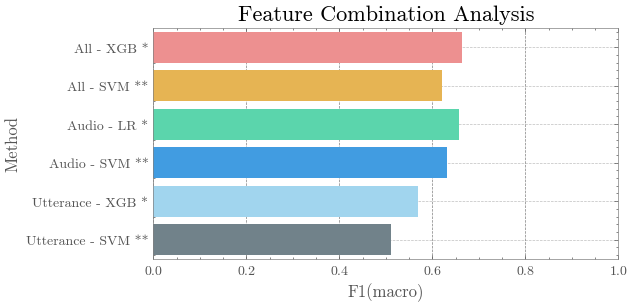

In [ ]:
plot_result(selected_results, col='Method', metric='F1(macro)', sort=True, title="Feature Combination Analysis", save_path="results/ml_result/compare_feature_ml_metric_f1.png")

## Gender Based Approach
- Female-Only model
- Male-Only Model

In [17]:
# 여성 데이터만 활용해서 여성 우울 분류
F_pipeline = MLPipeline(df.loc[df['Gender'] == 0], feature_cols=all_columns)
F_result, F_report = F_pipeline.evaluate_models(baseline=True, report=True)
display(F_result)

,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,Baseline (Majority Voting),0.708333,0.414634,0.500000,0.354167,0.500000
1,SVM,0.625000,0.590133,0.739496,0.592857,0.609244
2,KNN,0.833333,0.747368,0.735294,0.904762,0.714286
3,RandomForest,0.791667,0.705160,0.542017,0.775000,0.684874
4,LogisticRegression,0.791667,0.736264,0.714286,0.750000,0.726891
5,GradientBoosting,0.750000,0.697479,0.546218,0.697479,0.697479
6,XGBoost,0.625000,0.525275,0.588235,0.527778,0.525210


In [18]:
# 남성 데이터만 활용해서 남성 우울 분류
M_pipeline = MLPipeline(df.loc[df['Gender'] == 1], feature_cols=all_columns)
M_result, M_report = M_pipeline.evaluate_models(baseline=True, report=True)
display(M_result)

,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,Baseline (Majority Voting),0.695652,0.410256,0.500000,0.347826,0.500000
1,SVM,0.391304,0.329167,0.294643,0.341270,0.321429
2,KNN,0.695652,0.410256,0.325893,0.347826,0.500000
3,RandomForest,0.695652,0.410256,0.767857,0.347826,0.500000
4,LogisticRegression,0.521739,0.410256,0.321429,0.406863,0.415179
5,GradientBoosting,0.695652,0.516517,0.669643,0.607143,0.540179
6,XGBoost,0.739130,0.546053,0.723214,0.863636,0.571429
